# Bollinger Band

This script is using the yfinance library to download historical stock data for a specified ticker symbol, using the 'start' parameter to specify a start date of '2022-01-23'. The script then converts the date column to a datetime object, sets it as the index, and sorts the data by date. It then takes a copy of the last 365 days of data, and calculates the moving average, upper and lower Bollinger Bands of the close prices.
It then splits the data into features (moving average, upper and lower Bollinger Bands) and target (close prices), and fits an HistGradientBoostingRegressor model to the data. The script then makes predictions for the next 30 days using the last data point of moving average, upper and lower Bollinger Bands. The script also adds some random values to the predicted prices, and concatenates the last year's data and the predictions dataframe. Finally, the script plots the predicted close prices for the next 30 days with Bollinger Bands.

Enter the stock ticker symbol (or type 'exit' to quit): IDFCFIRSTB


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IDFCFIRSTB']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No data available for the stock ticker symbol: IDFCFIRSTB. Please try a different one.
Enter the stock ticker symbol (or type 'exit' to quit): GOOG


[*********************100%%**********************]  1 of 1 completed


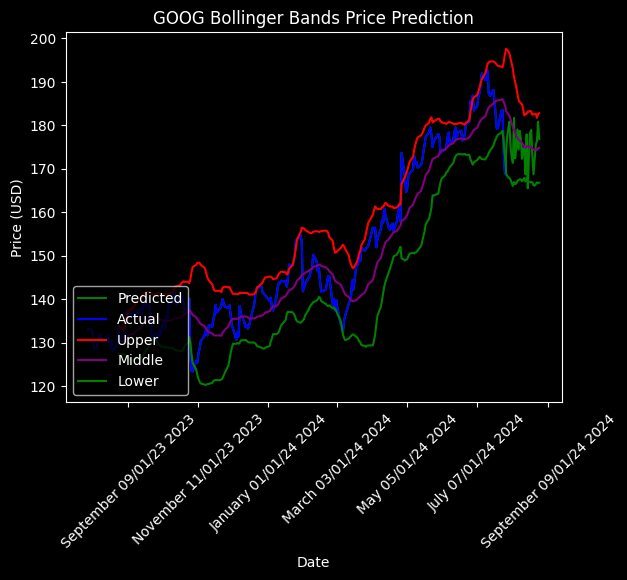

KeyboardInterrupt: Interrupted by user

In [ ]:
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated.*")

def fetch_and_predict(stock_ticker, data):
    # Convert the date column to a datetime object
    data['Date'] = pd.to_datetime(data.index)

    # Set the date column as the index
    data.set_index('Date', inplace=True)

    # Sort the data by date
    data.sort_index(inplace=True)

    # Get the data for the last year
    last_year = data.iloc[-365:].copy()

    # Calculate the moving average
    last_year.loc[:,'MA'] = last_year['Close'].rolling(window=20).mean()

    # Calculate the upper and lower Bollinger Bands
    last_year.loc[:,'Upper'] = last_year['MA'] + (last_year['Close'].rolling(window=20).std() * 2)
    last_year.loc[:,'Lower'] = last_year['MA'] - (last_year['Close'].rolling(window=20).std() * 2)

    # Split the data into X (features) and y (target)
    X = last_year[['MA', 'Upper', 'Lower']]
    y = last_year['Close']

    # Create an HistGradientBoostingRegressor instance
    model = HistGradientBoostingRegressor()

    # Fit the model with the data
    model.fit(X, y)

    # Make predictions for the next 30 days
    future_dates = pd.date_range(start=data.index[-1], periods=30, freq='D')
    future_data = pd.DataFrame(index=future_dates, columns=['MA','Upper','Lower'])
    future_data['MA'] = last_year['MA'].iloc[-1]
    future_data['Upper'] = last_year['Upper'].iloc[-1]
    future_data['Lower'] = last_year['Lower'].iloc[-1]

    predictions = model.predict(future_data)
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Calculate the standard deviation of the last year's close prices
    std_dev = last_year['Close'].std()

    # Generate random values with a standard deviation of 0.5 * the last year's close prices standard deviation
    random_values = np.random.normal(0, 0.2 * std_dev, predictions.shape)

    # Add the random values to the predicted prices
    predictions += random_values
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Concatenate the last_year and predictions dataframes
    predictions_df = pd.concat([last_year, predictions_df])

    # Recalculate upper and lower Bollinger Bands for the next 30 days
    predictions_df.loc[:,'MA'] = predictions_df['Close'].rolling(window=20).mean()
    predictions_df.loc[:,'Upper'] = predictions_df['MA'] + (predictions_df['Close'].rolling(window=20).std() * 2)
    predictions_df.loc[:,'Lower'] = predictions_df['MA'] - (predictions_df['Close'].rolling(window=20).std() * 2)

    # Set the style to dark theme
    style.use('dark_background')

    # Create the plot
    fig, ax = plt.subplots()

    # Plot the predicted close prices for the next 30 days
    ax.plot(predictions_df.index, predictions_df['Close'], color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red', label='Predicted')

    # Plot the actual close prices for the last year
    ax.plot(last_year.index, last_year['Close'], color='blue', label='Actual')

    # Plot the predicted upper Bollinger Band for the next 30 days
    ax.plot(predictions_df.index, predictions_df['Upper'], color='red', label='Upper')

    # Plot the moving average for the actual close prices for the last year
    ax.plot(last_year.index, last_year['MA'], color='purple', label='Middle')

    # Plot the predicted moving average for the next 30 days
    ax.plot(predictions_df.index[-30:], predictions_df['MA'][-30:], color='purple')

    # Plot the predicted lower Bollinger Band for the next 30 days
    ax.plot(predictions_df.index, predictions_df['Lower'], color='green', label='Lower')

    # Set x-axis as date format
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %D %Y"))
    plt.xticks(rotation=45)

    # Set the x-axis label
    plt.xlabel('Date')

    # Set the y-axis label
    plt.ylabel('Price (USD)')

    # Set the plot title
    plt.title(stock_ticker.upper() + " Bollinger Bands Price Prediction")

    # Show the legend
    plt.legend(loc='lower left')

    # Show the plot
    plt.show()

# Function to get a valid stock ticker from the user
def get_valid_stock_ticker():
    while True:
        stock_ticker = input("Enter the stock ticker symbol (or type 'exit' to quit): ")
        if stock_ticker.lower() == 'exit':
            return None, None
        data = yf.download(stock_ticker, start=one_year_ago, end=today)
        if data.empty:
            print(f"No data available for the stock ticker symbol: {stock_ticker}. Please try a different one.")
        else:
            return stock_ticker, data

# Main loop
while True:
    today = datetime.datetime.now().date()
    one_year_ago = today - datetime.timedelta(days=365)

    stock_ticker, data = get_valid_stock_ticker()
    if stock_ticker is None:
        break

    fetch_and_predict(stock_ticker, data)

Enter the stock ticker symbol (or type 'exit' to quit): GOOG


[*********************100%%**********************]  1 of 1 completed


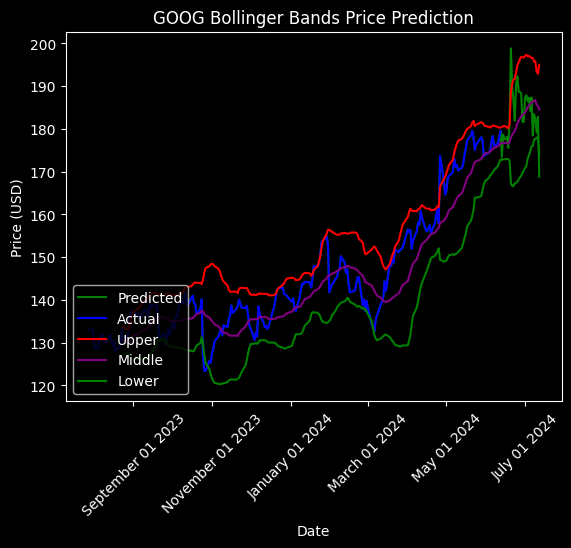

In [ ]:
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated.*")

def fetch_and_predict(stock_ticker, data):
    # Convert the date column to a datetime object
    data['Date'] = pd.to_datetime(data.index)

    # Set the date column as the index
    data.set_index('Date', inplace=True)

    # Sort the data by date
    data.sort_index(inplace=True)

    # Get the data for the last year
    last_year = data.iloc[-365:].copy()

    # Calculate the moving average
    last_year.loc[:,'MA'] = last_year['Close'].rolling(window=20).mean()

    # Calculate the upper and lower Bollinger Bands
    last_year.loc[:,'Upper'] = last_year['MA'] + (last_year['Close'].rolling(window=20).std() * 2)
    last_year.loc[:,'Lower'] = last_year['MA'] - (last_year['Close'].rolling(window=20).std() * 2)

    # Define the period for the prediction (30 days before today)
    prediction_period = last_year.iloc[-30:].copy()

    # Split the data into X (features) and y (target)
    X = last_year[['MA', 'Upper', 'Lower']]
    y = last_year['Close']

    # Create an HistGradientBoostingRegressor instance
    model = HistGradientBoostingRegressor()

    # Fit the model with the data
    model.fit(X, y)

    # Make predictions for the last 30 days
    future_dates = pd.date_range(start=last_year.index[-30], periods=30, freq='D')
    future_data = pd.DataFrame(index=future_dates, columns=['MA','Upper','Lower'])
    future_data['MA'] = prediction_period['MA'].values
    future_data['Upper'] = prediction_period['Upper'].values
    future_data['Lower'] = prediction_period['Lower'].values

    predictions = model.predict(future_data)
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Calculate the standard deviation of the last year's close prices
    std_dev = last_year['Close'].std()

    # Generate random values with a standard deviation of 0.2 * the last year's close prices standard deviation
    random_values = np.random.normal(0, 0.2 * std_dev, predictions.shape)

    # Add the random values to the predicted prices
    predictions += random_values
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Concatenate the last_year and predictions dataframes
    predictions_df = pd.concat([last_year.iloc[:-30], predictions_df])

    # Recalculate upper and lower Bollinger Bands for the predicted period
    predictions_df.loc[:,'MA'] = predictions_df['Close'].rolling(window=20).mean()
    predictions_df.loc[:,'Upper'] = predictions_df['MA'] + (predictions_df['Close'].rolling(window=20).std() * 2)
    predictions_df.loc[:,'Lower'] = predictions_df['MA'] - (predictions_df['Close'].rolling(window=20).std() * 2)

    # Set the style to dark theme
    style.use('dark_background')

    # Create the plot
    fig, ax = plt.subplots()

    # Plot the predicted close prices for the last 30 days
    ax.plot(predictions_df.index, predictions_df['Close'], color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red', label='Predicted')

    # Plot the actual close prices for the last year excluding the prediction period
    ax.plot(last_year.index[:-30], last_year['Close'].iloc[:-30], color='blue', label='Actual')

    # Plot the predicted upper Bollinger Band for the last 30 days
    ax.plot(predictions_df.index, predictions_df['Upper'], color='red', label='Upper')

    # Plot the moving average for the actual close prices for the last year excluding the prediction period
    ax.plot(last_year.index[:-30], last_year['MA'].iloc[:-30], color='purple', label='Middle')

    # Plot the predicted moving average for the last 30 days
    ax.plot(predictions_df.index[-30:], predictions_df['MA'][-30:], color='purple')

    # Plot the predicted lower Bollinger Band for the last 30 days
    ax.plot(predictions_df.index, predictions_df['Lower'], color='green', label='Lower')

    # Set x-axis as date format
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %d %Y"))
    plt.xticks(rotation=45)

    # Set the x-axis label
    plt.xlabel('Date')

    # Set the y-axis label
    plt.ylabel('Price (USD)')

    # Set the plot title
    plt.title(stock_ticker.upper() + " Bollinger Bands Price Prediction")

    # Show the legend
    plt.legend(loc='lower left')

    # Show the plot
    plt.show()

# Function to get a valid stock ticker from the user
def get_valid_stock_ticker():
    while True:
        stock_ticker = input("Enter the stock ticker symbol (or type 'exit' to quit): ")
        if stock_ticker.lower() == 'exit':
            return None, None
        data = yf.download(stock_ticker, start=one_year_ago, end=today)
        if data.empty:
            print(f"No data available for the stock ticker symbol: {stock_ticker}. Please try a different one.")
        else:
            return stock_ticker, data

# Main loop
while True:
    today = datetime.datetime.now().date()
    one_year_ago = today - datetime.timedelta(days=365)

    stock_ticker, data = get_valid_stock_ticker()
    if stock_ticker is None:
        break

    fetch_and_predict(stock_ticker, data)


In [3]:
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated.*")

def fetch_and_predict(stock_ticker, data):
    # Convert the date column to a datetime object
    data['Date'] = pd.to_datetime(data.index)

    # Set the date column as the index
    data.set_index('Date', inplace=True)

    # Sort the data by date
    data.sort_index(inplace=True)

    # Get the data for the last year
    last_year = data.iloc[-365:].copy()

    # Calculate the moving average
    last_year['MA'] = last_year['Close'].rolling(window=20).mean()

    # Calculate the upper and lower Bollinger Bands
    last_year['Upper'] = last_year['MA'] + (last_year['Close'].rolling(window=20).std() * 2)
    last_year['Lower'] = last_year['MA'] - (last_year['Close'].rolling(window=20).std() * 2)

    # Define the period for the prediction (30 days before today)
    prediction_period = last_year.iloc[-30:].copy()

    # Split the data into X (features) and y (target)
    X = last_year[['MA', 'Upper', 'Lower']]
    y = last_year['Close']

    # Create an HistGradientBoostingRegressor instance
    model = HistGradientBoostingRegressor()

    # Fit the model with the data
    model.fit(X, y)

    # Make predictions for the last 30 days
    future_dates = pd.date_range(start=last_year.index[-30], periods=30, freq='D')
    future_data = pd.DataFrame(index=future_dates, columns=['MA','Upper','Lower'])
    future_data['MA'] = prediction_period['MA'].values
    future_data['Upper'] = prediction_period['Upper'].values
    future_data['Lower'] = prediction_period['Lower'].values

    predictions = model.predict(future_data)
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Calculate the standard deviation of the last year's close prices
    std_dev = last_year['Close'].std()

    # Generate random values with a standard deviation of 0.2 * the last year's close prices standard deviation
    random_values = np.random.normal(0, 0.2 * std_dev, predictions.shape)

    # Add the random values to the predicted prices
    predictions += random_values
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Concatenate the last_year and predictions dataframes
    predictions_df = pd.concat([last_year.iloc[:-30], predictions_df])

    # Recalculate upper and lower Bollinger Bands for the predicted period
    predictions_df['MA'] = predictions_df['Close'].rolling(window=20).mean()
    predictions_df['Upper'] = predictions_df['MA'] + (predictions_df['Close'].rolling(window=20).std() * 2)
    predictions_df['Lower'] = predictions_df['MA'] - (predictions_df['Close'].rolling(window=20).std() * 2)

    # Set the style to dark theme
    style.use('dark_background')

    # Create the plot
    fig, ax = plt.subplots()

    # Plot the predicted close prices for the last 30 days
    ax.plot(predictions_df.index, predictions_df['Close'], color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red', label='Predicted')

    # Plot the actual close prices for the last year excluding the prediction period
    ax.plot(last_year.index[:-30], last_year['Close'].iloc[:-30], color='blue', label='Actual')

    # Plot the predicted upper Bollinger Band for the last 30 days
    ax.plot(predictions_df.index, predictions_df['Upper'], color='red', label='Upper')

    # Plot the moving average for the actual close prices for the last year excluding the prediction period
    ax.plot(last_year.index[:-30], last_year['MA'].iloc[:-30], color='purple', label='Middle')

    # Plot the predicted moving average for the last 30 days
    ax.plot(predictions_df.index[-30:], predictions_df['MA'][-30:], color='purple')

    # Plot the predicted lower Bollinger Band for the last 30 days
    ax.plot(predictions_df.index, predictions_df['Lower'], color='green', label='Lower')

    # Set x-axis as date format
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %d %Y"))
    plt.xticks(rotation=45)

    # Set the x-axis label
    plt.xlabel('Date')

    # Set the y-axis label
    plt.ylabel('Price (USD)')

    # Set the plot title
    plt.title(stock_ticker.upper() + " Bollinger Bands Price Prediction")

    # Show the legend
    plt.legend(loc='lower left')

    # Show the plot
    plt.show()

# Function to get a valid stock ticker from the user
def get_valid_stock_ticker():
    today = datetime.datetime.now().date()
    one_year_ago = today - datetime.timedelta(days=365)

    while True:
        stock_ticker = input("Enter the stock ticker symbol (or type 'exit' to quit): ")
        if stock_ticker.lower() == 'exit':
            return None, None
        data = yf.download(stock_ticker, start=one_year_ago, end=today)
        if data.empty:
            print(f"No data available for the stock ticker symbol: {stock_ticker}. Please try a different one.")
        else:
            return stock_ticker, data

# Main loop
def main():
    while True:
        stock_ticker, data = get_valid_stock_ticker()
        if stock_ticker is None:
            break

        fetch_and_predict(stock_ticker, data)

if __name__ == "__main__":
    main()


Enter the stock ticker symbol (or type 'exit' to quit): exit
